## install lib for hugging face dataset

In [4]:
!pip install datasets
!pip install timm

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [5]:
# !pip uninstall torch torchvision -y
# !pip install torch torchvision --index-url https://download.pytorch.org/whl/cu122

## prepare dataset

In [6]:
# prepare dataset
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset

disease_train = load_dataset('gOLIVES/OLIVES_Dataset', 
                      'disease_classification', 
                      split='train',
                      cache_dir='/home/hice1/tzhao348/scratch/eyeDataset'
                     )

bio_test = load_dataset('gOLIVES/OLIVES_Dataset', 
                      'biomarker_detection', 
                      split='test',
                      cache_dir='/home/hice1/tzhao348/scratch/eyeDataset'
                     )

bio_train = load_dataset('gOLIVES/OLIVES_Dataset', 
                      'biomarker_detection', 
                      split='train',
                      cache_dir='/home/hice1/tzhao348/scratch/eyeDataset'
                     )

print('finish loading dataset')

disease_train = disease_train.with_format("torch")
bio_train = bio_train.with_format('torch')
bio_test = bio_test.with_format('torch')

print('disease_train data length before driling', len(disease_train))
print('bio_train data length before driling', len(bio_train))
print('bio_test data length before driling', len(bio_test))

# filter nan data
# disease_train_dril = disease_train.filter(lambda x: not torch.isnan(x['DRIL']).any())
# disease_train_undril = disease_train.filter(lambda x: torch.isnan(x['DRIL']).any())

bio_train_dril = bio_train.filter(lambda x: not (torch.isnan(x['B1']).any() or 
                                                torch.isnan(x['BCVA']).any() or 
                                                torch.isnan(x['CST']).any() or
                                                torch.isnan(x['Eye_ID']).any() or
                                                torch.isnan(x['Patient_ID']).any()
                                                ))

bio_test_dril = bio_test.filter(lambda x: not (torch.isnan(x['B1']).any() or 
                                                torch.isnan(x['BCVA']).any() or 
                                                torch.isnan(x['CST']).any() or
                                                torch.isnan(x['Eye_ID']).any() or
                                                torch.isnan(x['Patient_ID']).any()
                                                ))

# bio_train_undril = bio_train.filter(lambda x: torch.isnan(x['B1']).any())


# print('disease train dril data length:', len(disease_train_dril))
# print('disease train undril data length:', len(disease_train_undril))
print('bio train dril data length:', len(bio_train_dril)) 
# print('bio train undril data length:', len(bio_train_undril))
print('bio test dril data length:', len(bio_test_dril))
# print('bio test undril data length:', len(bio_test_undril))

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/38 [00:00<?, ?it/s]

finish loading dataset
disease_train data length before driling 78822
bio_train data length before driling 78822
bio_test data length before driling 3871
bio train dril data length: 17444
bio test dril data length: 0


### data correlation anaysis

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 示例：假设你的数据集包含每个样本的标签，形状为 (num_samples, 6)
# B1 到 B6 的标签
data = []
for idx in range(6):
    data.append(bio_train[f'B{idx+1}'].reshape(-1,1))
    
data_test = []
for idx in range(6):
    data_test.append(bio_test[f'B{idx+1}'].reshape(-1,1))

data_train = data

(78822, 6)
correlation matrix：
          B1        B2        B3        B4        B5        B6
B1  1.000000  0.095352 -0.051325 -0.003511  0.357108  0.411108
B2  0.095352  1.000000 -0.749824 -0.016059  0.090680  0.093280
B3 -0.051325 -0.749824  1.000000 -0.009351 -0.040210 -0.050638
B4 -0.003511 -0.016059 -0.009351  1.000000 -0.078434 -0.093470
B5  0.357108  0.090680 -0.040210 -0.078434  1.000000  0.710155
B6  0.411108  0.093280 -0.050638 -0.093470  0.710155  1.000000


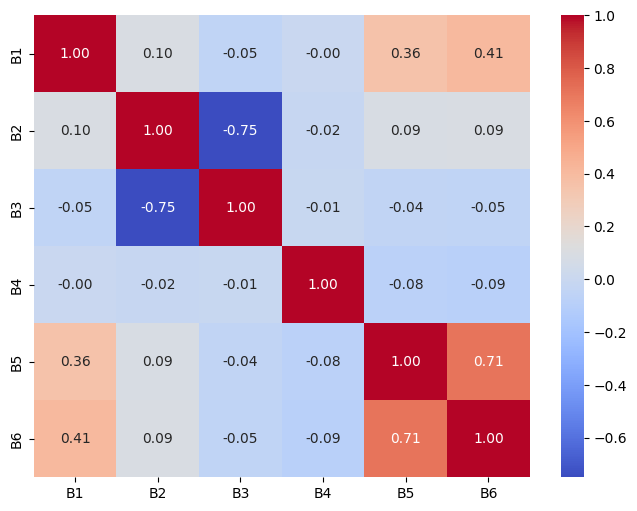

In [8]:
data = np.concatenate(data, axis=1)

print(data.shape)
# 将数据转为 Pandas DataFrame，方便计算相关性
columns = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6']
df = pd.DataFrame(data, columns=columns)

# 计算相关性矩阵
correlation_matrix = df.corr(method='pearson')  # 使用 Pearson 相关系数
# 如果数据是非线性的，也可以尝试 method='spearman'

print("correlation matrix：")
print(correlation_matrix)

# 可视化相关性矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True, fmt=".2f")
# plt.title("B1 to B6 Correlation Matrix")
plt.show()


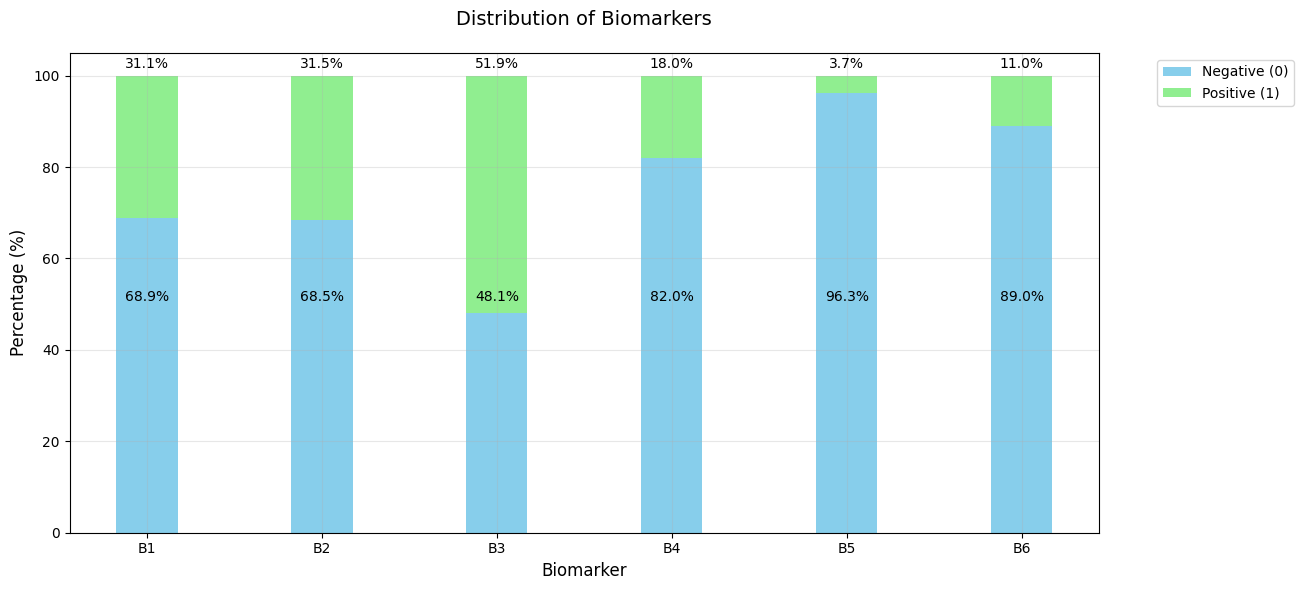

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# 计算每个biomarker的比例
proportions = []
for idx, data in enumerate(data_test):
    total_count = len(data)
    _, counts = np.unique(data, return_counts=True)
    props = counts / total_count * 100
    proportions.append(props)

proportions = np.array(proportions)

# 创建图形，调整图形大小
plt.figure(figsize=(12, 6))

# 设置柱状图的位置
x = np.arange(6)
width = 0.35

# 绘制堆叠柱状图
plt.bar(x, proportions[:, 0], width, label='Negative (0)', color='skyblue')
plt.bar(x, proportions[:, 1], width, bottom=proportions[:, 0], 
        label='Positive (1)', color='lightgreen')

# 自定义图形
plt.title('Distribution of Biomarkers', fontsize=14, pad=20)
plt.xlabel('Biomarker', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(x, [f'B{i+1}' for i in range(6)])

# 将图例移到图形外部右侧
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 添加百分比标签
for i in range(6):
    plt.text(i, 50, f'{proportions[i, 0]:.1f}%', ha='center', va='bottom')
    plt.text(i, proportions[i, 0] + proportions[i, 1] + 1, 
            f'{proportions[i, 1]:.1f}%', ha='center', va='bottom')

plt.grid(True, alpha=0.3)

# 调整布局，确保所有元素都可见
plt.tight_layout()

# 增加右侧边距以容纳图例
plt.subplots_adjust(right=0.92)

plt.show()

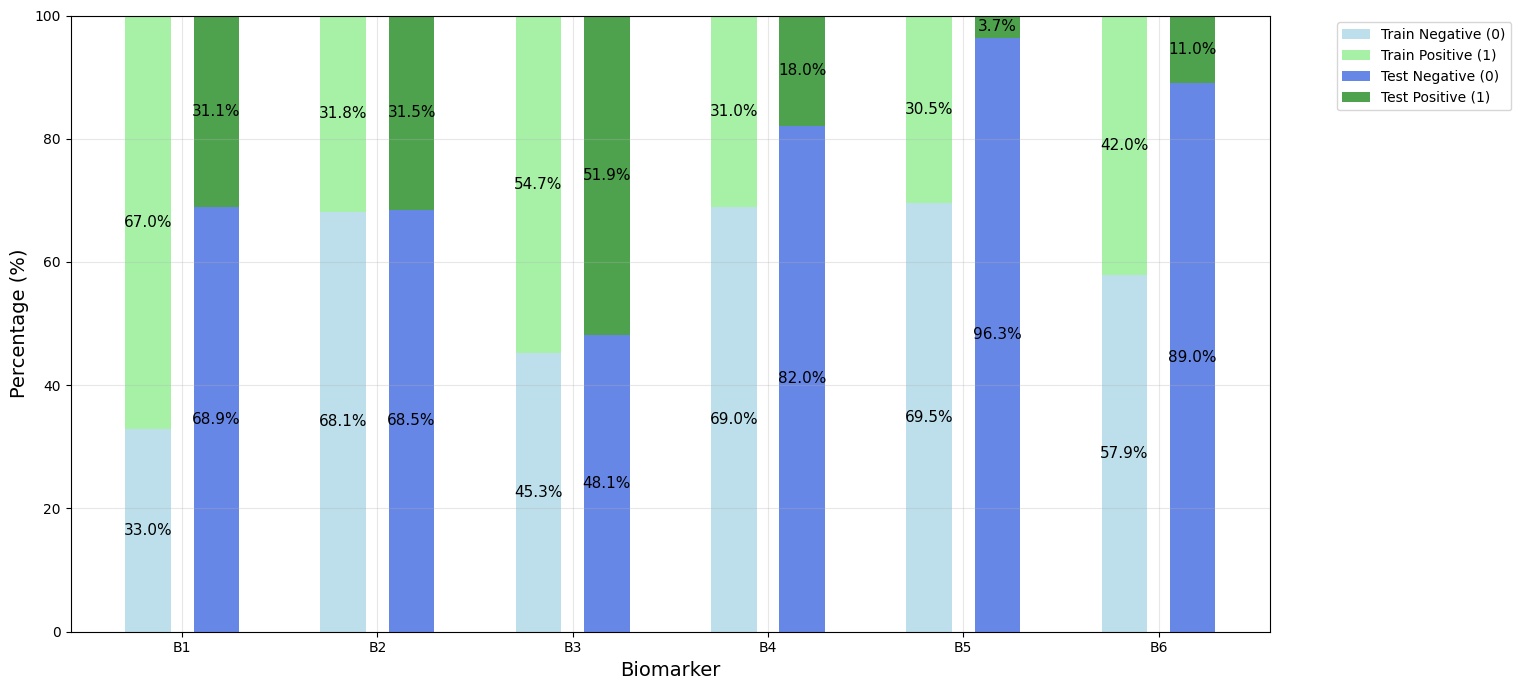

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 计算训练集的比例
train_proportions = []
for data in data_train:
    total_count = len(data)
    values, counts = np.unique(data, return_counts=True)
    props = counts / total_count * 100
    train_proportions.append(props)
train_proportions = 4.48 * np.array(train_proportions)

# 计算测试集的比例
test_proportions = []
for data in data_test:
    total_count = len(data)
    values, counts = np.unique(data, return_counts=True)
    props = counts / total_count * 100
    test_proportions.append(props)
test_proportions = np.array(test_proportions)

# 创建图形
plt.figure(figsize=(15, 7))

# 设置柱状图的位置
x = np.arange(6)
width = 0.35

# 训练集的柱状图
plt.bar(x - width/2, train_proportions[:, 0], width/1.5, 
        label='Train Negative (0)', color='lightblue', alpha=0.8)
plt.bar(x - width/2, train_proportions[:, 1], width/1.5, 
        bottom=train_proportions[:, 0], label='Train Positive (1)', 
        color='lightgreen', alpha=0.8)

# 测试集的柱状图
plt.bar(x + width/2, test_proportions[:, 0], width/1.5, 
        label='Test Negative (0)', color='royalblue', alpha=0.8)
plt.bar(x + width/2, test_proportions[:, 1], width/1.5, 
        bottom=test_proportions[:, 0], label='Test Positive (1)', 
        color='forestgreen', alpha=0.8)

# 自定义图形
# plt.title('Distribution of Biomarkers - Training vs Test Sets', fontsize=14, pad=20)
plt.xlabel('Biomarker', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(x, [f'B{i+1}' for i in range(6)])
plt.ylim(0, 100)  # 设置y轴范围为0-100%

# 添加图例
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 添加百分比标签
for i in range(6):
    # 训练集标签
    plt.text(i - width/2, train_proportions[i, 0]/2, 
             f'{train_proportions[i, 0]:.1f}%', ha='center', va='center', fontsize=11)
    plt.text(i - width/2, train_proportions[i, 0] + train_proportions[i, 1]/2, 
             f'{train_proportions[i, 1]:.1f}%', ha='center', va='center', fontsize=11)
    
    # 测试集标签
    plt.text(i + width/2, test_proportions[i, 0]/2, 
             f'{test_proportions[i, 0]:.1f}%', ha='center', va='center', fontsize=11)
    plt.text(i + width/2, test_proportions[i, 0] + test_proportions[i, 1]/2, 
             f'{test_proportions[i, 1]:.1f}%', ha='center', va='center', fontsize=11)

plt.grid(True, alpha=0.3)

# 调整布局
plt.tight_layout()
plt.subplots_adjust(right=0.85)

plt.show()

In [11]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import numpy as np  # 确保导入 numpy

class BiomarkerDatasetTransforms(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        
        # 计算 BCVA 和 CST 的统计信息用于归一化
        bcva_values = [data['BCVA'] for data in dataset]
        cst_values = [data['CST'] for data in dataset]
        eye_values = [data['Eye_ID'] for data in dataset]
        patient_values = [data['Patient_ID'] for data in dataset]
        
        # 计算均值和标准差
        self.bcva_mean = float(np.mean(bcva_values))
        self.bcva_std = float(np.std(bcva_values))
        self.cst_mean = float(np.mean(cst_values))
        self.cst_std = float(np.std(cst_values))
        self.eye_mean = float(np.mean(eye_values))
        self.eye_std = float(np.std(eye_values))
        self.patient_mean = float(np.mean(patient_values))
        self.patient_std = float(np.std(patient_values))
       
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image = self.dataset[idx]['Image']
        BCVA = self.dataset[idx]['BCVA']
        CST = self.dataset[idx]['CST']
        Eye_ID = self.dataset[idx]['Eye_ID']
        Patient_ID = self.dataset[idx]['Patient_ID']
        
        B1 = self.dataset[idx]['B1']
        B2 = self.dataset[idx]['B2']
        B3 = self.dataset[idx]['B3']
        B4 = self.dataset[idx]['B4']
        B5 = self.dataset[idx]['B5']
        B6 = self.dataset[idx]['B6']
        
        # 如果 image 是 tensor，确保它是 float 类型
        if isinstance(image, torch.Tensor):
            image = image.float() / 255.0  # 将 uint8 转换为 float 并归一化到 [0,1]
        
        if self.transform:
            image = self.transform(image)
            
        # 归一化 BCVA 和 CST
        BCVA = (BCVA - self.bcva_mean) / (self.bcva_std + 1e-8)
        CST = (CST - self.cst_mean) / (self.cst_std + 1e-8)
        
        # 归一化 Eye_ID 和 Patient_ID
        Eye_ID = (Eye_ID - self.eye_mean) / (self.eye_std + 1e-8)
        Patient_ID = (Patient_ID - self.patient_mean) / (self.patient_std + 1e-8)
        
        # 确保数据是 torch tensor
        BCVA = BCVA.clone().detach().to(torch.float32)
        CST = CST.clone().detach().to(torch.float32)
        Eye_ID = Eye_ID.clone().detach().to(torch.float32)
        Patient_ID = Patient_ID.clone().detach().to(torch.float32)
        
        # 将所有标签组合成一个 tensor
        label = torch.tensor([B1, B2, B3, B4, B5, B6], dtype=torch.float32)
        
        return image, BCVA, CST, Eye_ID, Patient_ID, label


## MultiModal Classification Model

In [12]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score
from torchvision.models import maxvit_t, MaxVit_T_Weights

import numpy as np

class ImageBranch(nn.Module):
    def __init__(self, output_dim=128, pretrained=True):
        super().__init__()
        print("Initializing ImageBranch...")
        
        self.backbone = maxvit_t(weights=MaxVit_T_Weights.IMAGENET1K_V1)
        
        # 修改第一个卷积层
        original_conv = self.backbone.stem[0][0]
        new_conv = nn.Conv2d(
            1,  # 单通道输入
            original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=original_conv.bias is not None
        )
        
        # 初始化新的卷积层
        if pretrained:
            with torch.no_grad():
                new_weight = original_conv.weight.mean(dim=1, keepdim=True)
                new_conv.weight.copy_(new_weight)
                if original_conv.bias is not None:
                    new_conv.bias.copy_(original_conv.bias)

        self.backbone.stem[0][0] = new_conv

        # 设置池化层
        self.pool = nn.Sequential(
            self.backbone.classifier[0],  # AdaptiveAvgPool2d
            self.backbone.classifier[1],  # Flatten
            self.backbone.classifier[2]   # LayerNorm
        )

        # 移除原始分类器
        self.backbone.classifier = nn.Identity()

        # 输出层
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, output_dim)
        )


    def forward(self, x):
        
        x = self.backbone(x)
        x = self.pool(x)
        x = self.fc(x)
        return x


# 其他类保持不变
class ClinicalBranch(nn.Module):
    def __init__(self, output_dim=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, output_dim)
        )
    
    def forward(self, x):
        return self.model(x)

class CrossModalAttention(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.feature_dim = feature_dim
        self.scale = (feature_dim ** -0.5)  # 缩放因子
        
        self.layer_norm = nn.LayerNorm(feature_dim)  # 添加LayerNorm
        self.query_proj = nn.Linear(feature_dim, feature_dim)
        self.key_proj = nn.Linear(feature_dim, feature_dim)
        self.value_proj = nn.Linear(feature_dim, feature_dim)
        
    def forward(self, img_features, clinical_features):
        # 应用LayerNorm
        img_features = self.layer_norm(img_features)
        clinical_features = self.layer_norm(clinical_features)
        
        queries = self.query_proj(img_features) * self.scale
        keys = self.key_proj(clinical_features)
        values = self.value_proj(clinical_features)
        
        # 使用更稳定的注意力计算
        attention = torch.matmul(queries, keys.transpose(-2, -1))
        attention = attention.clamp(min=-100, max=100)  # 防止极端值
        attention_weights = torch.softmax(attention, dim=-1)
        
        # 检查并处理无效值
        attention_weights = torch.nan_to_num(attention_weights, nan=1.0/attention_weights.size(-1))
        
        attended_features = torch.matmul(attention_weights, values)
        output = attended_features + img_features  # 残差连接
        return output

class MultiModalClassifier(nn.Module):
    def __init__(self, feature_dim=128):
        super().__init__()
        
        self.image_branch = ImageBranch(output_dim=feature_dim)
        self.clinical_branch = ClinicalBranch(output_dim=feature_dim)
        self.cross_attention = CrossModalAttention(feature_dim)
        
        # 改进分类器结构，添加更多的归一化层
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim * 2, feature_dim),
            nn.LayerNorm(feature_dim),  # 添加LayerNorm
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(feature_dim, feature_dim // 2),
            nn.LayerNorm(feature_dim // 2),  # 添加LayerNorm
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(feature_dim // 2, 6)
        )
        
    def forward(self, image, clinical_data):
        # 添加输入检查
        if torch.isnan(image).any() or torch.isinf(image).any():
            print("Warning: Invalid values in image input")
            image = torch.nan_to_num(image, nan=0.0, posinf=1.0, neginf=0.0)
            
        if torch.isnan(clinical_data).any() or torch.isinf(clinical_data).any():
            print("Warning: Invalid values in clinical_data input")
            clinical_data = torch.nan_to_num(clinical_data, nan=0.0, posinf=1.0, neginf=0.0)
        
        img_features = self.image_branch(image)
        clinical_features = self.clinical_branch(clinical_data)
        
        # 检查特征
        img_features = torch.nan_to_num(img_features)
        clinical_features = torch.nan_to_num(clinical_features)
        
        attended_features = self.cross_attention(img_features, clinical_features)
        combined = torch.cat([attended_features, clinical_features], dim=1)
        
        # 在最后应用sigmoid和clamp
        outputs = self.classifier(combined)
        outputs = torch.sigmoid(outputs)
        return outputs

In [13]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score
from torchvision.models import maxvit_t, MaxVit_T_Weights

import numpy as np

class ImageBranch(nn.Module):
    def __init__(self, output_dim=128, pretrained=True):
        super().__init__()
        print("Initializing ImageBranch...")
        
        self.backbone = maxvit_t(weights=MaxVit_T_Weights.IMAGENET1K_V1)
        
        # 修改第一个卷积层
        original_conv = self.backbone.stem[0][0]
        new_conv = nn.Conv2d(
            1,  # 单通道输入
            original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=original_conv.bias is not None
        )
        
        # 初始化新的卷积层
        if pretrained:
            with torch.no_grad():
                new_weight = original_conv.weight.mean(dim=1, keepdim=True)
                new_conv.weight.copy_(new_weight)
                if original_conv.bias is not None:
                    new_conv.bias.copy_(original_conv.bias)

        self.backbone.stem[0][0] = new_conv

        # 设置池化层
        self.pool = nn.Sequential(
            self.backbone.classifier[0],  # AdaptiveAvgPool2d
            self.backbone.classifier[1],  # Flatten
            self.backbone.classifier[2]   # LayerNorm
        )

        # 移除原始分类器
        self.backbone.classifier = nn.Identity()

        # 输出层
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        
        x = self.backbone(x)
        x = self.pool(x)
        x = self.fc(x)
        return x

class MaxvitClassifier(nn.Module):
    def __init__(self, feature_dim=128):
        super().__init__()
        
        self.image_branch = ImageBranch(output_dim=feature_dim)
        
        # 改进分类器结构，添加更多的归一化层
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, feature_dim),
            nn.LayerNorm(feature_dim),  # 添加LayerNorm
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(feature_dim, feature_dim // 2),
            nn.LayerNorm(feature_dim // 2),  # 添加LayerNorm
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(feature_dim // 2, 6)
        )
        
    def forward(self, image):
        # 添加输入检查
        if torch.isnan(image).any() or torch.isinf(image).any():
            print("Warning: Invalid values in image input")
            image = torch.nan_to_num(image, nan=0.0, posinf=1.0, neginf=0.0)
            
        img_features = self.image_branch(image)
        
        # 检查特征
        img_features = torch.nan_to_num(img_features)
        
        # 在最后应用sigmoid和clamp
        outputs = self.classifier(img_features)
        outputs = torch.sigmoid(outputs)
        return outputs

In [17]:
from tqdm import tqdm
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import os

def compute_metrics(outputs, targets):
    # 保持不变，因为输出格式没有改变
    predictions = (outputs > 0.5).float()
    
    metrics = {
        'accuracy': [],
        'f1': [],
        'Total_f1': None,
        'Total_Acc': None
    }
    
    for i in range(6):
        pred_i = predictions[:, i].cpu().numpy()
        target_i = targets[:, i].cpu().numpy()
        
        acc = accuracy_score(target_i, pred_i)
        f1 = f1_score(target_i, pred_i)
        
        metrics['accuracy'].append(acc)
        metrics['f1'].append(f1)
    
    all_predictions = predictions.cpu().numpy().flatten()
    all_targets = targets.cpu().numpy().flatten()
    
    total_acc = accuracy_score(all_targets, all_predictions)
    total_f1 = f1_score(all_targets, all_predictions)
    metrics['Total_Acc'] = total_acc
    metrics['Total_f1'] = total_f1
    
    return metrics

def train_model(model, model_name, train_loader, val_loader, metrics_all, preload=True, num_epochs=100, device='cuda'):
    print("Initializing training...")
    
    if preload == True:
        checkpoint_path = f'best_{model_name}_model.pth'
        if os.path.exists(checkpoint_path):
            try:
                print(f"Loading checkpoint from {checkpoint_path}")
                checkpoint = torch.load(checkpoint_path)
                model.load_state_dict(checkpoint)
                print("Successfully loaded checkpoint")
            except Exception as e:
                print(f"Error loading checkpoint: {str(e)}")
                print("Training will start from scratch")
        else:
            print("No checkpoint found, starting training from scratch")
    
    if not torch.cuda.is_available() and device == 'cuda':
        print("CUDA is not available, using CPU instead")
        device = 'cpu'
    
    try:
        # 确保模型在正确的设备上
        model = model.to(device)
        
        # 分别为backbone和新添加的层设置不同的学习率
        backbone_params = list(model.image_branch.backbone.parameters())
        other_params = (list(model.image_branch.fc.parameters()) +
                       list(model.clinical_branch.parameters()) +
                       list(model.cross_attention.parameters()) +
                       list(model.classifier.parameters()))
        
        optimizer = torch.optim.AdamW([
            {'params': backbone_params, 'lr': 1e-5},
            {'params': other_params, 'lr': 1e-4}
        ], weight_decay=0.01)
        
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=[1e-5, 1e-4],
            steps_per_epoch=len(train_loader),
            epochs=num_epochs,
            pct_start=0.1
        )
        
        criterion = nn.BCELoss()
        best_val_f1 = 0
        
        for epoch in range(num_epochs):
            print('------------------------------------------')
            print(f'Epoch: {epoch+1}/{num_epochs}')
            
            # 训练阶段
            model.train()
            train_loss = 0
            
            train_pbar = tqdm(train_loader, desc=f'Training Epoch {epoch+1}', 
                            leave=False, ncols=100)
            
            for batch in train_pbar:
                try:
                    image, bcva, cst, eyeID, patientID, targets = batch
                    
                    # 数据预处理和设备迁移
                    images = image.float().to(device)  # 确保是浮点数
                    
                    clinical_data = torch.stack([
                        bcva.float(),
                        cst.float()
                    ], dim=1).to(device)
                    
                    targets = targets.float().to(device)
                    
                    # 前向传播
                    optimizer.zero_grad()
                    outputs = model(images, clinical_data)
                    
                    # 损失计算
                    loss = criterion(outputs, targets)
                    
                    # 反向传播
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    scheduler.step()
                    
                    train_loss += loss.item()
                    train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
                    
                except Exception as e:
                    print(f"Error in training batch: {str(e)}")
                    raise e
            
            train_pbar.close()
            
            # 验证阶段
            model.eval()
            val_loss = 0
            all_outputs = []
            all_targets = []
            val_nan = 0
            
            with torch.no_grad():
#                 val_pbar = tqdm(val_loader, desc=f'Validation Epoch {epoch+1}', 
#                               leave=False, ncols=100)
                
                for batch in val_loader:
                    image, bcva, cst, eyeID, patientID, targets = batch
                    
                    # 数据预处理和设备迁移
                    images = image.float().to(device)
                    
                    clinical_data = torch.stack([
                        bcva.float(),
                        cst.float()
                    ], dim=1).to(device)
                    
                    targets = targets.float().to(device)
                    
                    outputs = model(images, clinical_data)
                    
                    if torch.isnan(outputs).any() or torch.isinf(outputs).any():
                        outputs = torch.nan_to_num(outputs, nan=0.5, posinf=1.0, neginf=0.0)
                        val_nan += 1
                    

                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
                    
                    all_outputs.append(outputs)
                    all_targets.append(targets)
#                     val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
                
#                 val_pbar.close()
            
            # 计算评估指标
            all_outputs = torch.cat(all_outputs, dim=0)
            all_targets = torch.cat(all_targets, dim=0)
            metrics = compute_metrics(all_outputs, all_targets)
           
            # 打印训练信息
            print(f'Train Loss: {train_loss/len(train_loader):.4f}')
            print(f'Val Loss: {val_loss/len(val_loader):.4f}')
            print(f'Val nan Number is {val_nan}')
            
            for i in range(6):
                print(f'Biomarker {i+1}:')
                print(f'  Accuracy: {metrics["accuracy"][i]:.4f}')
                print(f'  F1-score: {metrics["f1"][i]:.4f}')
                metrics_all[f"B{i+1} Acc"].append(metrics["accuracy"][i])
                metrics_all[f"B{i+1} F1"].append(metrics["f1"][i])

            print(f'Total Acc: {metrics["Total_Acc"]:.4f}')
            print(f'Total F1-Score: {metrics["Total_f1"]:.4f}')
            metrics_all["Total_Acc"].append(metrics["Total_Acc"])
            metrics_all["Total_f1"].append(metrics["Total_f1"])
            
            # 保存最佳模型
            avg_f1 = np.mean(metrics['f1'])
            if avg_f1 > best_val_f1:
                best_val_f1 = avg_f1
                torch.save(model.state_dict(), f'best_{model_name}_model.pth')
                print('Saving best model...')
                
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        raise e
        
def train_maxvit_model(model, model_name, train_loader, val_loader, num_epochs=100, device='cuda'):
    print("Initializing training...")
    
    checkpoint_path = f'best_{model_name}_model.pth'
    if os.path.exists(checkpoint_path):
        try:
            print(f"Loading checkpoint from {checkpoint_path}")
            checkpoint = torch.load(checkpoint_path)
            model.load_state_dict(checkpoint)
            print("Successfully loaded checkpoint")
        except Exception as e:
            print(f"Error loading checkpoint: {str(e)}")
            print("Training will start from scratch")
    else:
        print("No checkpoint found, starting training from scratch")
    
    if not torch.cuda.is_available() and device == 'cuda':
        print("CUDA is not available, using CPU instead")
        device = 'cpu'
    
    try:
        # 确保模型在正确的设备上
        model = model.to(device)
        
        # 分别为backbone和新添加的层设置不同的学习率
        backbone_params = list(model.image_branch.backbone.parameters())
        other_params = (list(model.image_branch.fc.parameters()) +
                       list(model.classifier.parameters()))
        
        optimizer = torch.optim.AdamW([
            {'params': backbone_params, 'lr': 1e-5},
            {'params': other_params, 'lr': 1e-4}
        ], weight_decay=0.01)
        
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=[1e-5, 1e-4],
            steps_per_epoch=len(train_loader),
            epochs=num_epochs,
            pct_start=0.1
        )
        
        criterion = nn.BCELoss()
        best_val_f1 = 0
        
        for epoch in range(num_epochs):
            print('------------------------------------------')
            print(f'Epoch: {epoch+1}/{num_epochs}')
            
            # 训练阶段
            model.train()
            train_loss = 0
            
            train_pbar = tqdm(train_loader, desc=f'Training Epoch {epoch+1}', 
                            leave=False, ncols=100)
            
            for batch in train_pbar:
                try:
                    image, bcva, cst, eyeID, patientID, targets = batch
                    
                    # 数据预处理和设备迁移
                    images = image.float().to(device)  # 确保是浮点数
                    
                    targets = targets.float().to(device)
                    
                    # 前向传播
                    optimizer.zero_grad()
                    outputs = model(images)
                    
                    # 损失计算
                    loss = criterion(outputs, targets)
                    
                    # 反向传播
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    scheduler.step()
                    
                    train_loss += loss.item()
                    train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
                    
                except Exception as e:
                    print(f"Error in training batch: {str(e)}")
                    raise e
            
            train_pbar.close()
            
            # 验证阶段
            model.eval()
            val_loss = 0
            all_outputs = []
            all_targets = []
            val_nan = 0
            
            with torch.no_grad():
#                 val_pbar = tqdm(val_loader, desc=f'Validation Epoch {epoch+1}', 
#                               leave=False, ncols=100)
                
                for batch in val_loader:
                    image, bcva, cst, eyeID, patientID, targets = batch
                    
                    # 数据预处理和设备迁移
                    images = image.float().to(device)
                    
                    targets = targets.float().to(device)
                    
                    outputs = model(images)
                    
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
                    
                    all_outputs.append(outputs)
                    all_targets.append(targets)
#                     val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
                
#                 val_pbar.close()
            
            # 计算评估指标
            all_outputs = torch.cat(all_outputs, dim=0)
            all_targets = torch.cat(all_targets, dim=0)
            metrics = compute_metrics(all_outputs, all_targets)
            
            # 打印训练信息
            print(f'Train Loss: {train_loss/len(train_loader):.4f}')
            print(f'Val Loss: {val_loss/len(val_loader):.4f}')
            print(f'Val nan Number is {val_nan}')
            
            for i in range(6):
                print(f'Biomarker {i+1}:')
                print(f'  Accuracy: {metrics["accuracy"][i]:.4f}')
                print(f'  F1-score: {metrics["f1"][i]:.4f}')
            print(f'Total Acc: {metrics["Total_Acc"]:.4f}')
            print(f'Total F1-Score: {metrics["Total_f1"]:.4f}')
            
            # 保存最佳模型
            avg_f1 = np.mean(metrics['f1'])
            if avg_f1 > best_val_f1:
                best_val_f1 = avg_f1
                torch.save(model.state_dict(), f'best_{model_name}_model.pth')
                print('Saving best model...')
                
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        raise e

In [19]:
import os

# Covert into a Format Usable by Pytorch

# Phase 1 Transformations
phase1_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 强制转换为单通道灰度图
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), antialias=True),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.1706], std=[0.2112])
])

print('start preparing dataset')

# apply transformation to dataset
bio_train_transform = BiomarkerDatasetTransforms(bio_train_dril, transform=phase1_transforms)
bio_test_transform = BiomarkerDatasetTransforms(bio_test, transform=phase1_transforms)

# set batch_size and num_workers
batch_size = 64
num_workers = 8

print('start preparing dataloader')

# prepare data loader
bio_train_loader = DataLoader(bio_train_transform, batch_size=batch_size, num_workers=num_workers, persistent_workers=True)
bio_test_loader  = DataLoader(bio_test_transform, batch_size=batch_size, num_workers=num_workers, persistent_workers=True)

print('finish preparing dataloader')

start preparing dataset
start preparing dataloader
finish preparing dataloader


## maxvit + mlp + cross attention

In [20]:
# 初始化模型和转换
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model = MultiModalClassifier()

model_name = 'maxvit_MMC_2_clinic'    

metrics_all = {}


# 初始化生物标记物的指标列表
for i in range(6):
    metrics_all[f"B{i+1} Acc"] = []
    metrics_all[f"B{i+1} F1"] = []

# 初始化总体指标列表
metrics_all["Total_Acc"] = []
metrics_all["Total_f1"] = []

# 训练模型
train_model(model, model_name, bio_train_loader, bio_test_loader, metrics_all, preload=False, device=device)

Initializing ImageBranch...
Initializing training...
------------------------------------------
Epoch: 1/100


Train Loss: 0.7199
Val Loss: 0.6469
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.4379
  F1-score: 0.4163
Biomarker 2:
  Accuracy: 0.4438
  F1-score: 0.4173
Biomarker 3:
  Accuracy: 0.5316
  F1-score: 0.3840
Biomarker 4:
  Accuracy: 0.6466
  F1-score: 0.1886
Biomarker 5:
  Accuracy: 0.9615
  F1-score: 0.0132
Biomarker 6:
  Accuracy: 0.7360
  F1-score: 0.1483
Total Acc: 0.6262
Total F1-Score: 0.3523
Saving best model...
------------------------------------------
Epoch: 2/100


Train Loss: 0.6808
Val Loss: 0.6177
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.3128
  F1-score: 0.4749
Biomarker 2:
  Accuracy: 0.6228
  F1-score: 0.1638
Biomarker 3:
  Accuracy: 0.5846
  F1-score: 0.6870
Biomarker 4:
  Accuracy: 0.8199
  F1-score: 0.0000
Biomarker 5:
  Accuracy: 0.9628
  F1-score: 0.0000
Biomarker 6:
  Accuracy: 0.8427
  F1-score: 0.0978
Total Acc: 0.6909
Total F1-Score: 0.4670
------------------------------------------
Epoch: 3/100


Train Loss: 0.6555
Val Loss: 0.6126
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.3115
  F1-score: 0.4747
Biomarker 2:
  Accuracy: 0.6823
  F1-score: 0.0097
Biomarker 3:
  Accuracy: 0.5490
  F1-score: 0.6739
Biomarker 4:
  Accuracy: 0.8205
  F1-score: 0.0000
Biomarker 5:
  Accuracy: 0.9631
  F1-score: 0.0138
Biomarker 6:
  Accuracy: 0.7939
  F1-score: 0.3037
Total Acc: 0.6867
Total F1-Score: 0.4671
------------------------------------------
Epoch: 4/100


Train Loss: 0.6301
Val Loss: 0.5672
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.3113
  F1-score: 0.4746
Biomarker 2:
  Accuracy: 0.6864
  F1-score: 0.0304
Biomarker 3:
  Accuracy: 0.5254
  F1-score: 0.6726
Biomarker 4:
  Accuracy: 0.8205
  F1-score: 0.0000
Biomarker 5:
  Accuracy: 0.9514
  F1-score: 0.4503
Biomarker 6:
  Accuracy: 0.8259
  F1-score: 0.3724
Total Acc: 0.6868
Total F1-Score: 0.4822
Saving best model...
------------------------------------------
Epoch: 5/100


Train Loss: 0.5837
Val Loss: 0.5157
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.3586
  F1-score: 0.4798
Biomarker 2:
  Accuracy: 0.6846
  F1-score: 0.0000
Biomarker 3:
  Accuracy: 0.5221
  F1-score: 0.6840
Biomarker 4:
  Accuracy: 0.8205
  F1-score: 0.0000
Biomarker 5:
  Accuracy: 0.9532
  F1-score: 0.5147
Biomarker 6:
  Accuracy: 0.8982
  F1-score: 0.4647
Total Acc: 0.7062
Total F1-Score: 0.5001
Saving best model...
------------------------------------------
Epoch: 6/100


Train Loss: 0.5531
Val Loss: 0.5032
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.5017
  F1-score: 0.5157
Biomarker 2:
  Accuracy: 0.6851
  F1-score: 0.0000
Biomarker 3:
  Accuracy: 0.5234
  F1-score: 0.6827
Biomarker 4:
  Accuracy: 0.8205
  F1-score: 0.0000
Biomarker 5:
  Accuracy: 0.9481
  F1-score: 0.4962
Biomarker 6:
  Accuracy: 0.9062
  F1-score: 0.5352
Total Acc: 0.7308
Total F1-Score: 0.5150
Saving best model...
------------------------------------------
Epoch: 7/100


Train Loss: 0.5324
Val Loss: 0.4891
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7213
  F1-score: 0.5323
Biomarker 2:
  Accuracy: 0.6856
  F1-score: 0.0033
Biomarker 3:
  Accuracy: 0.5185
  F1-score: 0.6740
Biomarker 4:
  Accuracy: 0.8205
  F1-score: 0.0000
Biomarker 5:
  Accuracy: 0.9504
  F1-score: 0.5294
Biomarker 6:
  Accuracy: 0.9093
  F1-score: 0.5806
Total Acc: 0.7676
Total F1-Score: 0.5174
Saving best model...
------------------------------------------
Epoch: 8/100


Train Loss: 0.5148
Val Loss: 0.4753
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7223
  F1-score: 0.5523
Biomarker 2:
  Accuracy: 0.6854
  F1-score: 0.0016
Biomarker 3:
  Accuracy: 0.5378
  F1-score: 0.6833
Biomarker 4:
  Accuracy: 0.8215
  F1-score: 0.0114
Biomarker 5:
  Accuracy: 0.9532
  F1-score: 0.5418
Biomarker 6:
  Accuracy: 0.9148
  F1-score: 0.6341
Total Acc: 0.7725
Total F1-Score: 0.5310
Saving best model...
------------------------------------------
Epoch: 9/100


Train Loss: 0.4894
Val Loss: 0.4505
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7238
  F1-score: 0.5544
Biomarker 2:
  Accuracy: 0.7055
  F1-score: 0.2017
Biomarker 3:
  Accuracy: 0.7086
  F1-score: 0.7745
Biomarker 4:
  Accuracy: 0.8197
  F1-score: 0.3223
Biomarker 5:
  Accuracy: 0.9522
  F1-score: 0.5499
Biomarker 6:
  Accuracy: 0.9248
  F1-score: 0.6712
Total Acc: 0.8058
Total F1-Score: 0.5956
Saving best model...
------------------------------------------
Epoch: 10/100


Train Loss: 0.4583
Val Loss: 0.4281
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7329
  F1-score: 0.5897
Biomarker 2:
  Accuracy: 0.7665
  F1-score: 0.5282
Biomarker 3:
  Accuracy: 0.7807
  F1-score: 0.8176
Biomarker 4:
  Accuracy: 0.8156
  F1-score: 0.3929
Biomarker 5:
  Accuracy: 0.9525
  F1-score: 0.5233
Biomarker 6:
  Accuracy: 0.9235
  F1-score: 0.6574
Total Acc: 0.8286
Total F1-Score: 0.6543
Saving best model...
------------------------------------------
Epoch: 11/100


Train Loss: 0.4298
Val Loss: 0.4187
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.6905
  F1-score: 0.5773
Biomarker 2:
  Accuracy: 0.7825
  F1-score: 0.6355
Biomarker 3:
  Accuracy: 0.7887
  F1-score: 0.8216
Biomarker 4:
  Accuracy: 0.8094
  F1-score: 0.4401
Biomarker 5:
  Accuracy: 0.9540
  F1-score: 0.5340
Biomarker 6:
  Accuracy: 0.9251
  F1-score: 0.6697
Total Acc: 0.8250
Total F1-Score: 0.6698
Saving best model...
------------------------------------------
Epoch: 12/100


Train Loss: 0.4106
Val Loss: 0.4144
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7063
  F1-score: 0.6020
Biomarker 2:
  Accuracy: 0.7820
  F1-score: 0.6301
Biomarker 3:
  Accuracy: 0.7848
  F1-score: 0.8170
Biomarker 4:
  Accuracy: 0.8094
  F1-score: 0.4668
Biomarker 5:
  Accuracy: 0.9540
  F1-score: 0.5436
Biomarker 6:
  Accuracy: 0.9295
  F1-score: 0.7003
Total Acc: 0.8277
Total F1-Score: 0.6765
Saving best model...
------------------------------------------
Epoch: 13/100


Train Loss: 0.3938
Val Loss: 0.4098
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7112
  F1-score: 0.6044
Biomarker 2:
  Accuracy: 0.7858
  F1-score: 0.6492
Biomarker 3:
  Accuracy: 0.7879
  F1-score: 0.8176
Biomarker 4:
  Accuracy: 0.8003
  F1-score: 0.4829
Biomarker 5:
  Accuracy: 0.9607
  F1-score: 0.5778
Biomarker 6:
  Accuracy: 0.9264
  F1-score: 0.6735
Total Acc: 0.8287
Total F1-Score: 0.6797
Saving best model...
------------------------------------------
Epoch: 14/100


Train Loss: 0.3828
Val Loss: 0.4079
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.6815
  F1-score: 0.6039
Biomarker 2:
  Accuracy: 0.7931
  F1-score: 0.6647
Biomarker 3:
  Accuracy: 0.7920
  F1-score: 0.8221
Biomarker 4:
  Accuracy: 0.7985
  F1-score: 0.4765
Biomarker 5:
  Accuracy: 0.9651
  F1-score: 0.5897
Biomarker 6:
  Accuracy: 0.9336
  F1-score: 0.7083
Total Acc: 0.8273
Total F1-Score: 0.6848
Saving best model...
------------------------------------------
Epoch: 15/100


Train Loss: 0.3704
Val Loss: 0.4040
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7337
  F1-score: 0.6366
Biomarker 2:
  Accuracy: 0.7789
  F1-score: 0.6409
Biomarker 3:
  Accuracy: 0.7864
  F1-score: 0.8135
Biomarker 4:
  Accuracy: 0.7970
  F1-score: 0.5044
Biomarker 5:
  Accuracy: 0.9625
  F1-score: 0.5821
Biomarker 6:
  Accuracy: 0.9341
  F1-score: 0.7092
Total Acc: 0.8321
Total F1-Score: 0.6871
Saving best model...
------------------------------------------
Epoch: 16/100


Train Loss: 0.3606
Val Loss: 0.4103
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7133
  F1-score: 0.6358
Biomarker 2:
  Accuracy: 0.7915
  F1-score: 0.6517
Biomarker 3:
  Accuracy: 0.7745
  F1-score: 0.8064
Biomarker 4:
  Accuracy: 0.8068
  F1-score: 0.4987
Biomarker 5:
  Accuracy: 0.9636
  F1-score: 0.5937
Biomarker 6:
  Accuracy: 0.9323
  F1-score: 0.6995
Total Acc: 0.8303
Total F1-Score: 0.6868
------------------------------------------
Epoch: 17/100


Train Loss: 0.3503
Val Loss: 0.4206
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.6854
  F1-score: 0.6194
Biomarker 2:
  Accuracy: 0.7794
  F1-score: 0.6194
Biomarker 3:
  Accuracy: 0.7753
  F1-score: 0.8110
Biomarker 4:
  Accuracy: 0.8006
  F1-score: 0.5252
Biomarker 5:
  Accuracy: 0.9633
  F1-score: 0.5799
Biomarker 6:
  Accuracy: 0.9321
  F1-score: 0.6952
Total Acc: 0.8227
Total F1-Score: 0.6800
------------------------------------------
Epoch: 18/100


Train Loss: 0.3429
Val Loss: 0.4046
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7481
  F1-score: 0.6566
Biomarker 2:
  Accuracy: 0.7763
  F1-score: 0.6202
Biomarker 3:
  Accuracy: 0.7716
  F1-score: 0.8051
Biomarker 4:
  Accuracy: 0.8081
  F1-score: 0.5160
Biomarker 5:
  Accuracy: 0.9713
  F1-score: 0.6312
Biomarker 6:
  Accuracy: 0.9365
  F1-score: 0.6993
Total Acc: 0.8353
Total F1-Score: 0.6893
Saving best model...
------------------------------------------
Epoch: 19/100


Train Loss: 0.3339
Val Loss: 0.4125
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7468
  F1-score: 0.6535
Biomarker 2:
  Accuracy: 0.7742
  F1-score: 0.6020
Biomarker 3:
  Accuracy: 0.7660
  F1-score: 0.8036
Biomarker 4:
  Accuracy: 0.8021
  F1-score: 0.5109
Biomarker 5:
  Accuracy: 0.9633
  F1-score: 0.5617
Biomarker 6:
  Accuracy: 0.9367
  F1-score: 0.7080
Total Acc: 0.8315
Total F1-Score: 0.6835
------------------------------------------
Epoch: 20/100


Train Loss: 0.3302
Val Loss: 0.4142
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7404
  F1-score: 0.6571
Biomarker 2:
  Accuracy: 0.7771
  F1-score: 0.6086
Biomarker 3:
  Accuracy: 0.7678
  F1-score: 0.8043
Biomarker 4:
  Accuracy: 0.8094
  F1-score: 0.5054
Biomarker 5:
  Accuracy: 0.9682
  F1-score: 0.6192
Biomarker 6:
  Accuracy: 0.9341
  F1-score: 0.7132
Total Acc: 0.8328
Total F1-Score: 0.6877
------------------------------------------
Epoch: 21/100


Train Loss: 0.3237
Val Loss: 0.4274
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7220
  F1-score: 0.6467
Biomarker 2:
  Accuracy: 0.7701
  F1-score: 0.6117
Biomarker 3:
  Accuracy: 0.7507
  F1-score: 0.7849
Biomarker 4:
  Accuracy: 0.8075
  F1-score: 0.5069
Biomarker 5:
  Accuracy: 0.9677
  F1-score: 0.6082
Biomarker 6:
  Accuracy: 0.9372
  F1-score: 0.7285
Total Acc: 0.8259
Total F1-Score: 0.6778
------------------------------------------
Epoch: 22/100


Train Loss: 0.3171
Val Loss: 0.4350
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7171
  F1-score: 0.6457
Biomarker 2:
  Accuracy: 0.7716
  F1-score: 0.5798
Biomarker 3:
  Accuracy: 0.7355
  F1-score: 0.7817
Biomarker 4:
  Accuracy: 0.8032
  F1-score: 0.5052
Biomarker 5:
  Accuracy: 0.9664
  F1-score: 0.5779
Biomarker 6:
  Accuracy: 0.9321
  F1-score: 0.6967
Total Acc: 0.8210
Total F1-Score: 0.6700
------------------------------------------
Epoch: 23/100


Train Loss: 0.3122
Val Loss: 0.4375
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7344
  F1-score: 0.6557
Biomarker 2:
  Accuracy: 0.7629
  F1-score: 0.5916
Biomarker 3:
  Accuracy: 0.7352
  F1-score: 0.7725
Biomarker 4:
  Accuracy: 0.7967
  F1-score: 0.5163
Biomarker 5:
  Accuracy: 0.9669
  F1-score: 0.6000
Biomarker 6:
  Accuracy: 0.9336
  F1-score: 0.7089
Total Acc: 0.8216
Total F1-Score: 0.6704
------------------------------------------
Epoch: 24/100


Train Loss: 0.3073
Val Loss: 0.4430
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7122
  F1-score: 0.6425
Biomarker 2:
  Accuracy: 0.7559
  F1-score: 0.5904
Biomarker 3:
  Accuracy: 0.7468
  F1-score: 0.7832
Biomarker 4:
  Accuracy: 0.8016
  F1-score: 0.5083
Biomarker 5:
  Accuracy: 0.9687
  F1-score: 0.6033
Biomarker 6:
  Accuracy: 0.9326
  F1-score: 0.7017
Total Acc: 0.8196
Total F1-Score: 0.6698
------------------------------------------
Epoch: 25/100


Train Loss: 0.3036
Val Loss: 0.4423
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7616
  F1-score: 0.6733
Biomarker 2:
  Accuracy: 0.7530
  F1-score: 0.5533
Biomarker 3:
  Accuracy: 0.7295
  F1-score: 0.7741
Biomarker 4:
  Accuracy: 0.8055
  F1-score: 0.5133
Biomarker 5:
  Accuracy: 0.9695
  F1-score: 0.6118
Biomarker 6:
  Accuracy: 0.9344
  F1-score: 0.7019
Total Acc: 0.8256
Total F1-Score: 0.6707
------------------------------------------
Epoch: 26/100


Train Loss: 0.2974
Val Loss: 0.4482
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7388
  F1-score: 0.6597
Biomarker 2:
  Accuracy: 0.7525
  F1-score: 0.5772
Biomarker 3:
  Accuracy: 0.7331
  F1-score: 0.7713
Biomarker 4:
  Accuracy: 0.7685
  F1-score: 0.4862
Biomarker 5:
  Accuracy: 0.9711
  F1-score: 0.5971
Biomarker 6:
  Accuracy: 0.9354
  F1-score: 0.7045
Total Acc: 0.8166
Total F1-Score: 0.6625
------------------------------------------
Epoch: 27/100


Train Loss: 0.2960
Val Loss: 0.4492
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7378
  F1-score: 0.6560
Biomarker 2:
  Accuracy: 0.7569
  F1-score: 0.5621
Biomarker 3:
  Accuracy: 0.7383
  F1-score: 0.7812
Biomarker 4:
  Accuracy: 0.8019
  F1-score: 0.5055
Biomarker 5:
  Accuracy: 0.9716
  F1-score: 0.6207
Biomarker 6:
  Accuracy: 0.9346
  F1-score: 0.7141
Total Acc: 0.8235
Total F1-Score: 0.6709
------------------------------------------
Epoch: 28/100


Train Loss: 0.2883
Val Loss: 0.4712
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7205
  F1-score: 0.6498
Biomarker 2:
  Accuracy: 0.7484
  F1-score: 0.5149
Biomarker 3:
  Accuracy: 0.7184
  F1-score: 0.7731
Biomarker 4:
  Accuracy: 0.7817
  F1-score: 0.5118
Biomarker 5:
  Accuracy: 0.9700
  F1-score: 0.6000
Biomarker 6:
  Accuracy: 0.9359
  F1-score: 0.7123
Total Acc: 0.8125
Total F1-Score: 0.6594
------------------------------------------
Epoch: 29/100


Train Loss: 0.2861
Val Loss: 0.4818
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7453
  F1-score: 0.6651
Biomarker 2:
  Accuracy: 0.7422
  F1-score: 0.5064
Biomarker 3:
  Accuracy: 0.7125
  F1-score: 0.7656
Biomarker 4:
  Accuracy: 0.7463
  F1-score: 0.4912
Biomarker 5:
  Accuracy: 0.9685
  F1-score: 0.6090
Biomarker 6:
  Accuracy: 0.9359
  F1-score: 0.7169
Total Acc: 0.8084
Total F1-Score: 0.6533
------------------------------------------
Epoch: 30/100


Train Loss: 0.2813
Val Loss: 0.4816
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7308
  F1-score: 0.6621
Biomarker 2:
  Accuracy: 0.7486
  F1-score: 0.5242
Biomarker 3:
  Accuracy: 0.7068
  F1-score: 0.7613
Biomarker 4:
  Accuracy: 0.7582
  F1-score: 0.4874
Biomarker 5:
  Accuracy: 0.9721
  F1-score: 0.6115
Biomarker 6:
  Accuracy: 0.9370
  F1-score: 0.7169
Total Acc: 0.8089
Total F1-Score: 0.6546
------------------------------------------
Epoch: 31/100


Train Loss: 0.2771
Val Loss: 0.4860
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7688
  F1-score: 0.6843
Biomarker 2:
  Accuracy: 0.7388
  F1-score: 0.5386
Biomarker 3:
  Accuracy: 0.7083
  F1-score: 0.7543
Biomarker 4:
  Accuracy: 0.7463
  F1-score: 0.4875
Biomarker 5:
  Accuracy: 0.9700
  F1-score: 0.6000
Biomarker 6:
  Accuracy: 0.9380
  F1-score: 0.7327
Total Acc: 0.8117
Total F1-Score: 0.6563
------------------------------------------
Epoch: 32/100


Train Loss: 0.2751
Val Loss: 0.4811
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7458
  F1-score: 0.6630
Biomarker 2:
  Accuracy: 0.7419
  F1-score: 0.5308
Biomarker 3:
  Accuracy: 0.7151
  F1-score: 0.7618
Biomarker 4:
  Accuracy: 0.7577
  F1-score: 0.4897
Biomarker 5:
  Accuracy: 0.9718
  F1-score: 0.6254
Biomarker 6:
  Accuracy: 0.9344
  F1-score: 0.7107
Total Acc: 0.8111
Total F1-Score: 0.6542
------------------------------------------
Epoch: 33/100


Train Loss: 0.2704
Val Loss: 0.5104
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7481
  F1-score: 0.6648
Biomarker 2:
  Accuracy: 0.7339
  F1-score: 0.5267
Biomarker 3:
  Accuracy: 0.7034
  F1-score: 0.7525
Biomarker 4:
  Accuracy: 0.7226
  F1-score: 0.4766
Biomarker 5:
  Accuracy: 0.9644
  F1-score: 0.5714
Biomarker 6:
  Accuracy: 0.9269
  F1-score: 0.6993
Total Acc: 0.7999
Total F1-Score: 0.6435
------------------------------------------
Epoch: 34/100


Train Loss: 0.2699
Val Loss: 0.4979
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7399
  F1-score: 0.6708
Biomarker 2:
  Accuracy: 0.7455
  F1-score: 0.5395
Biomarker 3:
  Accuracy: 0.7029
  F1-score: 0.7528
Biomarker 4:
  Accuracy: 0.7520
  F1-score: 0.4766
Biomarker 5:
  Accuracy: 0.9690
  F1-score: 0.6026
Biomarker 6:
  Accuracy: 0.9367
  F1-score: 0.7281
Total Acc: 0.8077
Total F1-Score: 0.6534
------------------------------------------
Epoch: 35/100


Train Loss: 0.2658
Val Loss: 0.5212
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7781
  F1-score: 0.6927
Biomarker 2:
  Accuracy: 0.7295
  F1-score: 0.4677
Biomarker 3:
  Accuracy: 0.6910
  F1-score: 0.7526
Biomarker 4:
  Accuracy: 0.6887
  F1-score: 0.4525
Biomarker 5:
  Accuracy: 0.9669
  F1-score: 0.5844
Biomarker 6:
  Accuracy: 0.9352
  F1-score: 0.7183
Total Acc: 0.7982
Total F1-Score: 0.6394
------------------------------------------
Epoch: 36/100


Train Loss: 0.2599
Val Loss: 0.5096
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7768
  F1-score: 0.6872
Biomarker 2:
  Accuracy: 0.7306
  F1-score: 0.4939
Biomarker 3:
  Accuracy: 0.6941
  F1-score: 0.7487
Biomarker 4:
  Accuracy: 0.7246
  F1-score: 0.4670
Biomarker 5:
  Accuracy: 0.9687
  F1-score: 0.5926
Biomarker 6:
  Accuracy: 0.9349
  F1-score: 0.7206
Total Acc: 0.8050
Total F1-Score: 0.6443
------------------------------------------
Epoch: 37/100


Train Loss: 0.2569
Val Loss: 0.5404
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7399
  F1-score: 0.6656
Biomarker 2:
  Accuracy: 0.7192
  F1-score: 0.4942
Biomarker 3:
  Accuracy: 0.6804
  F1-score: 0.7356
Biomarker 4:
  Accuracy: 0.7096
  F1-score: 0.4637
Biomarker 5:
  Accuracy: 0.9677
  F1-score: 0.5847
Biomarker 6:
  Accuracy: 0.9318
  F1-score: 0.7227
Total Acc: 0.7914
Total F1-Score: 0.6327
------------------------------------------
Epoch: 38/100


Train Loss: 0.2558
Val Loss: 0.5390
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7703
  F1-score: 0.6871
Biomarker 2:
  Accuracy: 0.7313
  F1-score: 0.4763
Biomarker 3:
  Accuracy: 0.6820
  F1-score: 0.7470
Biomarker 4:
  Accuracy: 0.7109
  F1-score: 0.4648
Biomarker 5:
  Accuracy: 0.9654
  F1-score: 0.5649
Biomarker 6:
  Accuracy: 0.9331
  F1-score: 0.7277
Total Acc: 0.7988
Total F1-Score: 0.6418
------------------------------------------
Epoch: 39/100


Train Loss: 0.2502
Val Loss: 0.5380
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7944
  F1-score: 0.7050
Biomarker 2:
  Accuracy: 0.7254
  F1-score: 0.4489
Biomarker 3:
  Accuracy: 0.6776
  F1-score: 0.7447
Biomarker 4:
  Accuracy: 0.6944
  F1-score: 0.4571
Biomarker 5:
  Accuracy: 0.9706
  F1-score: 0.6096
Biomarker 6:
  Accuracy: 0.9346
  F1-score: 0.7229
Total Acc: 0.7995
Total F1-Score: 0.6390
------------------------------------------
Epoch: 40/100


Train Loss: 0.2490
Val Loss: 0.5432
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7815
  F1-score: 0.6928
Biomarker 2:
  Accuracy: 0.7303
  F1-score: 0.4701
Biomarker 3:
  Accuracy: 0.6815
  F1-score: 0.7461
Biomarker 4:
  Accuracy: 0.6877
  F1-score: 0.4421
Biomarker 5:
  Accuracy: 0.9690
  F1-score: 0.5804
Biomarker 6:
  Accuracy: 0.9344
  F1-score: 0.7269
Total Acc: 0.7974
Total F1-Score: 0.6370
------------------------------------------
Epoch: 41/100


Train Loss: 0.2491
Val Loss: 0.5251
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7670
  F1-score: 0.6853
Biomarker 2:
  Accuracy: 0.7401
  F1-score: 0.5317
Biomarker 3:
  Accuracy: 0.7029
  F1-score: 0.7565
Biomarker 4:
  Accuracy: 0.7189
  F1-score: 0.4661
Biomarker 5:
  Accuracy: 0.9698
  F1-score: 0.5895
Biomarker 6:
  Accuracy: 0.9326
  F1-score: 0.7178
Total Acc: 0.8052
Total F1-Score: 0.6516
------------------------------------------
Epoch: 42/100


Train Loss: 0.2431
Val Loss: 0.5508
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7616
  F1-score: 0.6834
Biomarker 2:
  Accuracy: 0.7244
  F1-score: 0.5174
Biomarker 3:
  Accuracy: 0.6944
  F1-score: 0.7447
Biomarker 4:
  Accuracy: 0.6755
  F1-score: 0.4428
Biomarker 5:
  Accuracy: 0.9687
  F1-score: 0.6109
Biomarker 6:
  Accuracy: 0.9323
  F1-score: 0.7213
Total Acc: 0.7928
Total F1-Score: 0.6372
------------------------------------------
Epoch: 43/100


Train Loss: 0.2422
Val Loss: 0.5648
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7784
  F1-score: 0.6944
Biomarker 2:
  Accuracy: 0.7169
  F1-score: 0.4442
Biomarker 3:
  Accuracy: 0.6804
  F1-score: 0.7447
Biomarker 4:
  Accuracy: 0.6531
  F1-score: 0.4416
Biomarker 5:
  Accuracy: 0.9695
  F1-score: 0.5630
Biomarker 6:
  Accuracy: 0.9362
  F1-score: 0.7386
Total Acc: 0.7891
Total F1-Score: 0.6301
------------------------------------------
Epoch: 44/100


Train Loss: 0.2395
Val Loss: 0.5703
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7592
  F1-score: 0.6821
Biomarker 2:
  Accuracy: 0.7236
  F1-score: 0.4351
Biomarker 3:
  Accuracy: 0.6740
  F1-score: 0.7470
Biomarker 4:
  Accuracy: 0.6879
  F1-score: 0.4559
Biomarker 5:
  Accuracy: 0.9711
  F1-score: 0.6000
Biomarker 6:
  Accuracy: 0.9357
  F1-score: 0.7279
Total Acc: 0.7919
Total F1-Score: 0.6347
------------------------------------------
Epoch: 45/100


Train Loss: 0.2366
Val Loss: 0.5545
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7789
  F1-score: 0.6903
Biomarker 2:
  Accuracy: 0.7210
  F1-score: 0.4872
Biomarker 3:
  Accuracy: 0.6941
  F1-score: 0.7508
Biomarker 4:
  Accuracy: 0.6967
  F1-score: 0.4580
Biomarker 5:
  Accuracy: 0.9708
  F1-score: 0.6169
Biomarker 6:
  Accuracy: 0.9313
  F1-score: 0.7218
Total Acc: 0.7988
Total F1-Score: 0.6416
------------------------------------------
Epoch: 46/100


Train Loss: 0.2334
Val Loss: 0.5650
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7838
  F1-score: 0.6949
Biomarker 2:
  Accuracy: 0.7267
  F1-score: 0.4971
Biomarker 3:
  Accuracy: 0.6779
  F1-score: 0.7384
Biomarker 4:
  Accuracy: 0.6675
  F1-score: 0.4387
Biomarker 5:
  Accuracy: 0.9716
  F1-score: 0.5833
Biomarker 6:
  Accuracy: 0.9334
  F1-score: 0.7273
Total Acc: 0.7935
Total F1-Score: 0.6343
------------------------------------------
Epoch: 47/100


Train Loss: 0.2318
Val Loss: 0.5549
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7939
  F1-score: 0.7040
Biomarker 2:
  Accuracy: 0.7174
  F1-score: 0.4815
Biomarker 3:
  Accuracy: 0.6812
  F1-score: 0.7388
Biomarker 4:
  Accuracy: 0.6815
  F1-score: 0.4518
Biomarker 5:
  Accuracy: 0.9700
  F1-score: 0.5735
Biomarker 6:
  Accuracy: 0.9367
  F1-score: 0.7363
Total Acc: 0.7968
Total F1-Score: 0.6364
------------------------------------------
Epoch: 48/100


Train Loss: 0.2275
Val Loss: 0.5680
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7709
  F1-score: 0.6887
Biomarker 2:
  Accuracy: 0.7329
  F1-score: 0.5024
Biomarker 3:
  Accuracy: 0.6866
  F1-score: 0.7469
Biomarker 4:
  Accuracy: 0.6624
  F1-score: 0.4455
Biomarker 5:
  Accuracy: 0.9711
  F1-score: 0.5821
Biomarker 6:
  Accuracy: 0.9349
  F1-score: 0.7261
Total Acc: 0.7931
Total F1-Score: 0.6378
------------------------------------------
Epoch: 49/100


Training Epoch 49:  18%|█████▍                        | 50/273 [00:09<00:29,  7.63it/s, loss=0.3410]

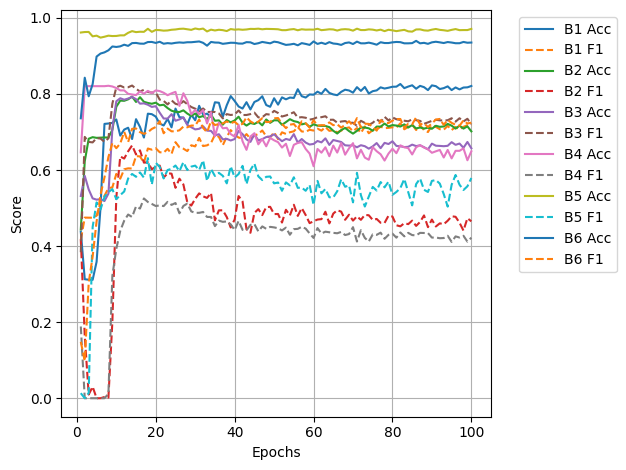

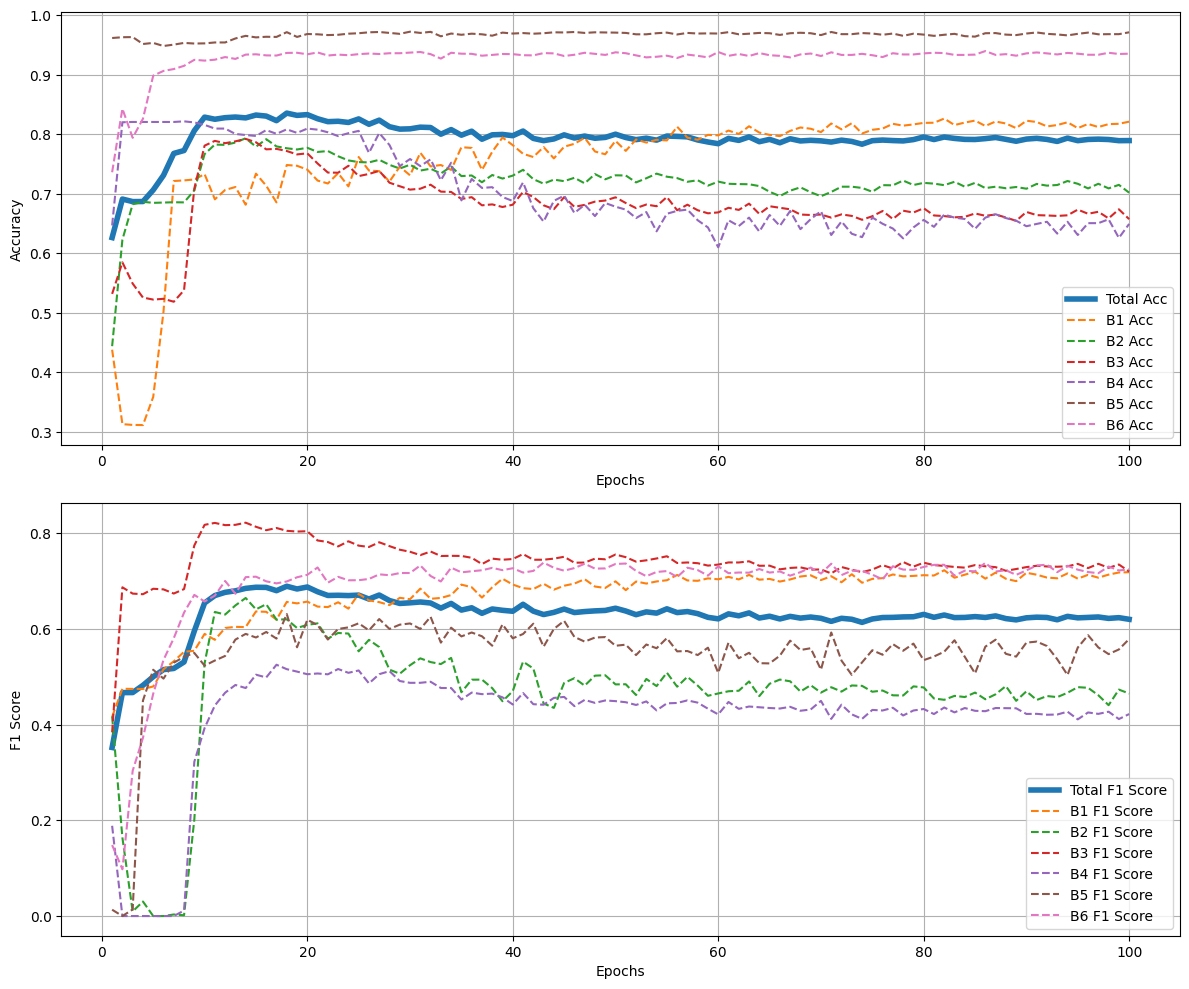

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# # 保存数据
# with open('metrics_all.pkl', 'wb') as f:
#     pickle.dump(metrics_all, f)

# 加载数据
with open('metrics_all.pkl', 'rb') as f:
    metrics_all = pickle.load(f)

epochs = range(1,101)

# Plot 2: Accuracy and F1 scores
plt.figure()
for i in range(6):
    plt.plot(epochs, metrics_all[f"B{i+1} Acc"], label=f'B{i+1} Acc')
    plt.plot(epochs, metrics_all[f"B{i+1} F1"], '--', label=f'B{i+1} F1')

plt.xlabel('Epochs')
plt.ylabel('Score')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Separate plots for accuracy and F1 scores for better clarity
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Accuracy plot
ax1.plot(epochs, metrics_all["Total_Acc"], linewidth=4,label='Total Acc' )
for i in range(6):
    ax1.plot(epochs, metrics_all[f"B{i+1} Acc"],'--', label=f'B{i+1} Acc')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.grid(True)
ax1.legend()

# F1 score plot
ax2.plot(epochs, metrics_all["Total_f1"], linewidth=4,label='Total F1 Score' )
for i in range(6):
    ax2.plot(epochs, metrics_all[f"B{i+1} F1"],'--', label=f'B{i+1} F1 Score')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('F1 Score')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

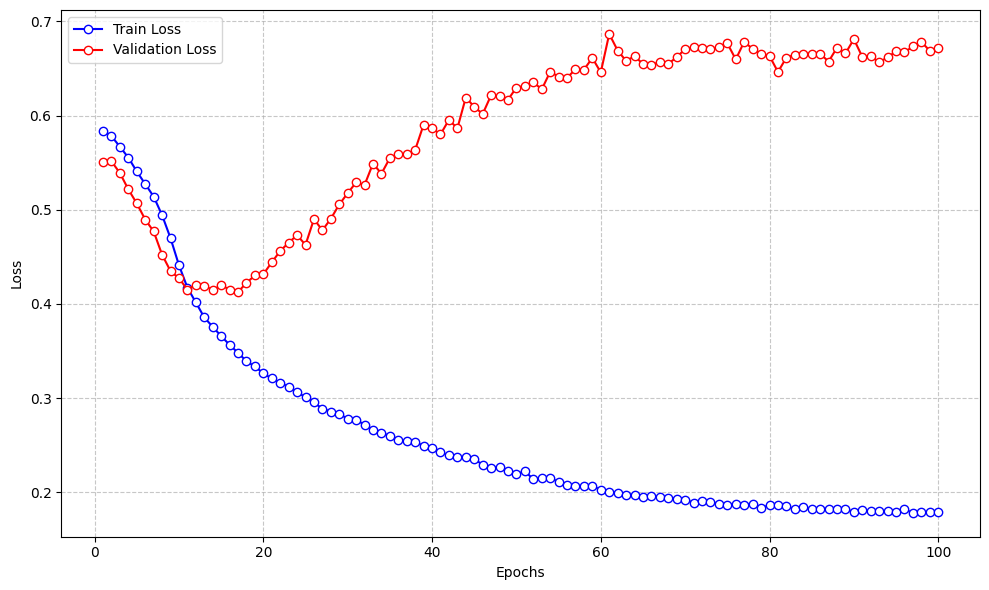

In [12]:
epochs = range(1, 101) 
train_loss = [0.5841,0.5781,0.5669,0.5553,0.5406,0.5273,0.5140,0.4942,0.4698,0.4411,0.4173,0.4016,0.3857,0.3757,0.3659,0.3566,0.3481,0.3392,0.3336,0.3263,0.3209,0.3161,0.3122,0.3064,0.3010,0.2955,0.2887,0.2858,0.2832,0.2781,0.2769,0.2718,0.2665,0.2634,0.2597,0.2556,0.2542,0.2531,0.2496,0.2472,0.2423,0.2394,0.2373,0.2376,0.2356,0.2291,0.2262,0.2265,0.2227,0.2192,0.2226,0.2138,0.2148,0.2147,0.2115,0.2077,0.2068,0.2064,0.2067,0.2027,0.2002,0.1995,0.1975,0.1974,0.1948,0.1959,0.1951,0.1944,0.1934,0.1921,0.1891,0.1909,0.1899,0.1879,0.1867,0.1877,0.1862,0.1877,0.1832,0.1865,0.1863,0.1850,0.1823,0.1843,0.1820,0.1826,0.1826,0.1828,0.1821,0.1792,0.1809,0.1802,0.1801,0.1802,0.1795,0.1818,0.1783,0.1789,0.1794,0.1793] 
val_loss = [0.5510,0.5514,0.5389,0.5216,0.5067,0.4896,0.4770,0.4522,0.4349,0.4272,0.4153,0.4205,0.4195,0.4147,0.4199,0.4152,0.4127,0.4223,0.4303,0.4315,0.4442,0.4562,0.4650,0.4730,0.4627,0.4900,0.4782,0.4904,0.5056,0.5176,0.5290,0.5263,0.5490,0.5383,0.5549,0.5591,0.5590,0.5636,0.5903,0.5864,0.5800,0.5954,0.5864,0.6191,0.6093,0.6016,0.6216,0.6204,0.6168,0.6297,0.6313,0.6356,0.6277,0.6464,0.6412,0.6400,0.6491,0.6487,0.6611,0.6458,0.6866,0.6690,0.6580,0.6629,0.6548,0.6537,0.6568,0.6549,0.6619,0.6706,0.6725,0.6716,0.6702,0.6724,0.6766,0.6596,0.6783,0.6707,0.6656,0.6632,0.6463,0.6614,0.6645,0.6656,0.6657,0.6656,0.6573,0.6720,0.6659,0.6811,0.6622,0.6633,0.6563,0.6620,0.6680,0.6672,0.6733,0.6783,0.6686,0.6717]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot training and validation loss
epochs = range(1, 101)
plt.plot(epochs, train_loss, 'b-o', label='Train Loss', markerfacecolor='white', markeredgecolor='blue')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss', markerfacecolor='white', markeredgecolor='red')

# Customize the plot
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Use tight layout to prevent label clipping
plt.tight_layout()

# Show the plot
plt.show()

## compare with maxvit

In [18]:
# 初始化模型和转换
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model = MaxvitClassifier()

model_name = 'maxvit'    

# 训练模型
train_maxvit_model(model, model_name, bio_train_loader, bio_test_loader, device=device)

Initializing ImageBranch...
Initializing training...
No checkpoint found, starting training from scratch
------------------------------------------
Epoch: 1/100


Train Loss: 0.7264
Val Loss: 0.7068
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.3555
  F1-score: 0.4503
Biomarker 2:
  Accuracy: 0.6830
  F1-score: 0.0823
Biomarker 3:
  Accuracy: 0.5099
  F1-score: 0.6258
Biomarker 4:
  Accuracy: 0.4250
  F1-score: 0.2782
Biomarker 5:
  Accuracy: 0.8011
  F1-score: 0.0655
Biomarker 6:
  Accuracy: 0.1258
  F1-score: 0.1970
Total Acc: 0.4834
Total F1-Score: 0.3707
Saving best model...
------------------------------------------
Epoch: 2/100


Train Loss: 0.6769
Val Loss: 0.6563
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.3113
  F1-score: 0.4742
Biomarker 2:
  Accuracy: 0.6851
  F1-score: 0.0000
Biomarker 3:
  Accuracy: 0.5239
  F1-score: 0.6616
Biomarker 4:
  Accuracy: 0.8194
  F1-score: 0.0000
Biomarker 5:
  Accuracy: 0.9579
  F1-score: 0.0121
Biomarker 6:
  Accuracy: 0.2237
  F1-score: 0.2078
Total Acc: 0.5869
Total F1-Score: 0.4147
------------------------------------------
Epoch: 3/100


Train Loss: 0.6471
Val Loss: 0.6325
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.3110
  F1-score: 0.4741
Biomarker 2:
  Accuracy: 0.6851
  F1-score: 0.0000
Biomarker 3:
  Accuracy: 0.5216
  F1-score: 0.6817
Biomarker 4:
  Accuracy: 0.8205
  F1-score: 0.0000
Biomarker 5:
  Accuracy: 0.9566
  F1-score: 0.3000
Biomarker 6:
  Accuracy: 0.6833
  F1-score: 0.3330
Total Acc: 0.6630
Total F1-Score: 0.4740
Saving best model...
------------------------------------------
Epoch: 4/100


Train Loss: 0.6087
Val Loss: 0.5405
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.5425
  F1-score: 0.5230
Biomarker 2:
  Accuracy: 0.6848
  F1-score: 0.0000
Biomarker 3:
  Accuracy: 0.5216
  F1-score: 0.6832
Biomarker 4:
  Accuracy: 0.8205
  F1-score: 0.0000
Biomarker 5:
  Accuracy: 0.9522
  F1-score: 0.4875
Biomarker 6:
  Accuracy: 0.8949
  F1-score: 0.4855
Total Acc: 0.7361
Total F1-Score: 0.5145
Saving best model...
------------------------------------------
Epoch: 5/100


Train Loss: 0.5700
Val Loss: 0.5167
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.6642
  F1-score: 0.5455
Biomarker 2:
  Accuracy: 0.6851
  F1-score: 0.0000
Biomarker 3:
  Accuracy: 0.5211
  F1-score: 0.6828
Biomarker 4:
  Accuracy: 0.8205
  F1-score: 0.0000
Biomarker 5:
  Accuracy: 0.9489
  F1-score: 0.4789
Biomarker 6:
  Accuracy: 0.9052
  F1-score: 0.4966
Total Acc: 0.7575
Total F1-Score: 0.5197
Saving best model...
------------------------------------------
Epoch: 6/100


Train Loss: 0.5447
Val Loss: 0.4994
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7414
  F1-score: 0.5167
Biomarker 2:
  Accuracy: 0.6851
  F1-score: 0.0000
Biomarker 3:
  Accuracy: 0.5273
  F1-score: 0.6855
Biomarker 4:
  Accuracy: 0.8205
  F1-score: 0.0000
Biomarker 5:
  Accuracy: 0.9437
  F1-score: 0.4883
Biomarker 6:
  Accuracy: 0.9096
  F1-score: 0.5592
Total Acc: 0.7712
Total F1-Score: 0.5180
Saving best model...
------------------------------------------
Epoch: 7/100


Train Loss: 0.5255
Val Loss: 0.4820
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7383
  F1-score: 0.5451
Biomarker 2:
  Accuracy: 0.6851
  F1-score: 0.0081
Biomarker 3:
  Accuracy: 0.5577
  F1-score: 0.6991
Biomarker 4:
  Accuracy: 0.8205
  F1-score: 0.0000
Biomarker 5:
  Accuracy: 0.9494
  F1-score: 0.5075
Biomarker 6:
  Accuracy: 0.9142
  F1-score: 0.5808
Total Acc: 0.7775
Total F1-Score: 0.5316
Saving best model...
------------------------------------------
Epoch: 8/100


Train Loss: 0.4965
Val Loss: 0.4417
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7280
  F1-score: 0.5432
Biomarker 2:
  Accuracy: 0.7479
  F1-score: 0.4874
Biomarker 3:
  Accuracy: 0.7468
  F1-score: 0.8002
Biomarker 4:
  Accuracy: 0.8192
  F1-score: 0.0113
Biomarker 5:
  Accuracy: 0.9584
  F1-score: 0.5413
Biomarker 6:
  Accuracy: 0.9129
  F1-score: 0.5674
Total Acc: 0.8189
Total F1-Score: 0.6158
Saving best model...
------------------------------------------
Epoch: 9/100


Train Loss: 0.4615
Val Loss: 0.4257
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7468
  F1-score: 0.5732
Biomarker 2:
  Accuracy: 0.7807
  F1-score: 0.6297
Biomarker 3:
  Accuracy: 0.7835
  F1-score: 0.8202
Biomarker 4:
  Accuracy: 0.8215
  F1-score: 0.0521
Biomarker 5:
  Accuracy: 0.9574
  F1-score: 0.5455
Biomarker 6:
  Accuracy: 0.9210
  F1-score: 0.6277
Total Acc: 0.8351
Total F1-Score: 0.6570
Saving best model...
------------------------------------------
Epoch: 10/100


Train Loss: 0.4335
Val Loss: 0.4200
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7236
  F1-score: 0.5843
Biomarker 2:
  Accuracy: 0.7889
  F1-score: 0.6574
Biomarker 3:
  Accuracy: 0.7933
  F1-score: 0.8253
Biomarker 4:
  Accuracy: 0.8225
  F1-score: 0.2459
Biomarker 5:
  Accuracy: 0.9551
  F1-score: 0.5348
Biomarker 6:
  Accuracy: 0.9207
  F1-score: 0.6483
Total Acc: 0.8340
Total F1-Score: 0.6704
Saving best model...
------------------------------------------
Epoch: 11/100


Train Loss: 0.4139
Val Loss: 0.4143
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7727
  F1-score: 0.6352
Biomarker 2:
  Accuracy: 0.7871
  F1-score: 0.6572
Biomarker 3:
  Accuracy: 0.7822
  F1-score: 0.8144
Biomarker 4:
  Accuracy: 0.8081
  F1-score: 0.3834
Biomarker 5:
  Accuracy: 0.9584
  F1-score: 0.5684
Biomarker 6:
  Accuracy: 0.9235
  F1-score: 0.6534
Total Acc: 0.8387
Total F1-Score: 0.6822
Saving best model...
------------------------------------------
Epoch: 12/100


Train Loss: 0.4000
Val Loss: 0.3985
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7856
  F1-score: 0.6238
Biomarker 2:
  Accuracy: 0.7892
  F1-score: 0.6477
Biomarker 3:
  Accuracy: 0.7944
  F1-score: 0.8273
Biomarker 4:
  Accuracy: 0.8156
  F1-score: 0.4387
Biomarker 5:
  Accuracy: 0.9584
  F1-score: 0.5589
Biomarker 6:
  Accuracy: 0.9261
  F1-score: 0.6643
Total Acc: 0.8449
Total F1-Score: 0.6900
Saving best model...
------------------------------------------
Epoch: 13/100


Train Loss: 0.3849
Val Loss: 0.4135
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7548
  F1-score: 0.6494
Biomarker 2:
  Accuracy: 0.7861
  F1-score: 0.6601
Biomarker 3:
  Accuracy: 0.7830
  F1-score: 0.8125
Biomarker 4:
  Accuracy: 0.7970
  F1-score: 0.4433
Biomarker 5:
  Accuracy: 0.9514
  F1-score: 0.5179
Biomarker 6:
  Accuracy: 0.9199
  F1-score: 0.6485
Total Acc: 0.8320
Total F1-Score: 0.6830
------------------------------------------
Epoch: 14/100


Train Loss: 0.3760
Val Loss: 0.4110
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7685
  F1-score: 0.6562
Biomarker 2:
  Accuracy: 0.7809
  F1-score: 0.6407
Biomarker 3:
  Accuracy: 0.7776
  F1-score: 0.8093
Biomarker 4:
  Accuracy: 0.8086
  F1-score: 0.4907
Biomarker 5:
  Accuracy: 0.9551
  F1-score: 0.5469
Biomarker 6:
  Accuracy: 0.9186
  F1-score: 0.6580
Total Acc: 0.8349
Total F1-Score: 0.6867
Saving best model...
------------------------------------------
Epoch: 15/100


Train Loss: 0.3674
Val Loss: 0.4062
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7765
  F1-score: 0.6793
Biomarker 2:
  Accuracy: 0.7732
  F1-score: 0.6209
Biomarker 3:
  Accuracy: 0.7858
  F1-score: 0.8178
Biomarker 4:
  Accuracy: 0.8163
  F1-score: 0.4844
Biomarker 5:
  Accuracy: 0.9556
  F1-score: 0.5401
Biomarker 6:
  Accuracy: 0.9256
  F1-score: 0.6712
Total Acc: 0.8388
Total F1-Score: 0.6930
Saving best model...
------------------------------------------
Epoch: 16/100


Train Loss: 0.3577
Val Loss: 0.4045
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7864
  F1-score: 0.6733
Biomarker 2:
  Accuracy: 0.7734
  F1-score: 0.6107
Biomarker 3:
  Accuracy: 0.7737
  F1-score: 0.8081
Biomarker 4:
  Accuracy: 0.8168
  F1-score: 0.5032
Biomarker 5:
  Accuracy: 0.9571
  F1-score: 0.5585
Biomarker 6:
  Accuracy: 0.9292
  F1-score: 0.6872
Total Acc: 0.8394
Total F1-Score: 0.6900
Saving best model...
------------------------------------------
Epoch: 17/100


Train Loss: 0.3470
Val Loss: 0.4126
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7613
  F1-score: 0.6723
Biomarker 2:
  Accuracy: 0.7763
  F1-score: 0.6124
Biomarker 3:
  Accuracy: 0.7724
  F1-score: 0.8078
Biomarker 4:
  Accuracy: 0.7975
  F1-score: 0.5075
Biomarker 5:
  Accuracy: 0.9607
  F1-score: 0.5801
Biomarker 6:
  Accuracy: 0.9238
  F1-score: 0.6711
Total Acc: 0.8320
Total F1-Score: 0.6875
Saving best model...
------------------------------------------
Epoch: 18/100


Train Loss: 0.3423
Val Loss: 0.4142
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7667
  F1-score: 0.6659
Biomarker 2:
  Accuracy: 0.7722
  F1-score: 0.5844
Biomarker 3:
  Accuracy: 0.7634
  F1-score: 0.8037
Biomarker 4:
  Accuracy: 0.7962
  F1-score: 0.5096
Biomarker 5:
  Accuracy: 0.9613
  F1-score: 0.5509
Biomarker 6:
  Accuracy: 0.9308
  F1-score: 0.6802
Total Acc: 0.8317
Total F1-Score: 0.6816
------------------------------------------
Epoch: 19/100


Train Loss: 0.3344
Val Loss: 0.4131
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7657
  F1-score: 0.6691
Biomarker 2:
  Accuracy: 0.7670
  F1-score: 0.5870
Biomarker 3:
  Accuracy: 0.7626
  F1-score: 0.8004
Biomarker 4:
  Accuracy: 0.8052
  F1-score: 0.5026
Biomarker 5:
  Accuracy: 0.9633
  F1-score: 0.5697
Biomarker 6:
  Accuracy: 0.9292
  F1-score: 0.6942
Total Acc: 0.8322
Total F1-Score: 0.6824
------------------------------------------
Epoch: 20/100


Train Loss: 0.3311
Val Loss: 0.4234
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7711
  F1-score: 0.6762
Biomarker 2:
  Accuracy: 0.7603
  F1-score: 0.5606
Biomarker 3:
  Accuracy: 0.7497
  F1-score: 0.7915
Biomarker 4:
  Accuracy: 0.7946
  F1-score: 0.4933
Biomarker 5:
  Accuracy: 0.9615
  F1-score: 0.5579
Biomarker 6:
  Accuracy: 0.9297
  F1-score: 0.6930
Total Acc: 0.8278
Total F1-Score: 0.6745
------------------------------------------
Epoch: 21/100


Train Loss: 0.3241
Val Loss: 0.4237
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7729
  F1-score: 0.6736
Biomarker 2:
  Accuracy: 0.7634
  F1-score: 0.5712
Biomarker 3:
  Accuracy: 0.7541
  F1-score: 0.7962
Biomarker 4:
  Accuracy: 0.7897
  F1-score: 0.4944
Biomarker 5:
  Accuracy: 0.9649
  F1-score: 0.5879
Biomarker 6:
  Accuracy: 0.9292
  F1-score: 0.6886
Total Acc: 0.8290
Total F1-Score: 0.6777
------------------------------------------
Epoch: 22/100


Train Loss: 0.3184
Val Loss: 0.4297
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7913
  F1-score: 0.6899
Biomarker 2:
  Accuracy: 0.7461
  F1-score: 0.4840
Biomarker 3:
  Accuracy: 0.7399
  F1-score: 0.7909
Biomarker 4:
  Accuracy: 0.7908
  F1-score: 0.4950
Biomarker 5:
  Accuracy: 0.9633
  F1-score: 0.5723
Biomarker 6:
  Accuracy: 0.9352
  F1-score: 0.7220
Total Acc: 0.8277
Total F1-Score: 0.6711
------------------------------------------
Epoch: 23/100


Train Loss: 0.3115
Val Loss: 0.4282
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7734
  F1-score: 0.6844
Biomarker 2:
  Accuracy: 0.7510
  F1-score: 0.5218
Biomarker 3:
  Accuracy: 0.7455
  F1-score: 0.7917
Biomarker 4:
  Accuracy: 0.8026
  F1-score: 0.4934
Biomarker 5:
  Accuracy: 0.9636
  F1-score: 0.5662
Biomarker 6:
  Accuracy: 0.9321
  F1-score: 0.7035
Total Acc: 0.8280
Total F1-Score: 0.6738
------------------------------------------
Epoch: 24/100


Train Loss: 0.3092
Val Loss: 0.4320
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7835
  F1-score: 0.6903
Biomarker 2:
  Accuracy: 0.7453
  F1-score: 0.5255
Biomarker 3:
  Accuracy: 0.7324
  F1-score: 0.7777
Biomarker 4:
  Accuracy: 0.7964
  F1-score: 0.5006
Biomarker 5:
  Accuracy: 0.9633
  F1-score: 0.5799
Biomarker 6:
  Accuracy: 0.9326
  F1-score: 0.7122
Total Acc: 0.8256
Total F1-Score: 0.6698
------------------------------------------
Epoch: 25/100


Train Loss: 0.3019
Val Loss: 0.4442
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7734
  F1-score: 0.6807
Biomarker 2:
  Accuracy: 0.7543
  F1-score: 0.5304
Biomarker 3:
  Accuracy: 0.7399
  F1-score: 0.7858
Biomarker 4:
  Accuracy: 0.7753
  F1-score: 0.5023
Biomarker 5:
  Accuracy: 0.9589
  F1-score: 0.5620
Biomarker 6:
  Accuracy: 0.9287
  F1-score: 0.7070
Total Acc: 0.8218
Total F1-Score: 0.6695
------------------------------------------
Epoch: 26/100


Train Loss: 0.2976
Val Loss: 0.4525
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7683
  F1-score: 0.6800
Biomarker 2:
  Accuracy: 0.7492
  F1-score: 0.5043
Biomarker 3:
  Accuracy: 0.7277
  F1-score: 0.7801
Biomarker 4:
  Accuracy: 0.7773
  F1-score: 0.5091
Biomarker 5:
  Accuracy: 0.9644
  F1-score: 0.5660
Biomarker 6:
  Accuracy: 0.9318
  F1-score: 0.7040
Total Acc: 0.8198
Total F1-Score: 0.6657
------------------------------------------
Epoch: 27/100


Train Loss: 0.2916
Val Loss: 0.4751
Val nan Number is 0
Biomarker 1:
  Accuracy: 0.7523
  F1-score: 0.6726
Biomarker 2:
  Accuracy: 0.7362
  F1-score: 0.4867
Biomarker 3:
  Accuracy: 0.7195
  F1-score: 0.7727
Biomarker 4:
  Accuracy: 0.7592
  F1-score: 0.5079
Biomarker 5:
  Accuracy: 0.9631
  F1-score: 0.5680
Biomarker 6:
  Accuracy: 0.9295
  F1-score: 0.7117
Total Acc: 0.8100
Total F1-Score: 0.6570
------------------------------------------
Epoch: 28/100


KeyboardInterrupt: 